## Set up

In [0]:
# dbutils.fs.ls("dbfs:/mnt/capstone")
# dbutils.fs.ls("s3://my-ec2-storage/data/binary_ddi")

In [0]:
import pyspark
from pyspark.sql.types import ArrayType, FloatType
import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, VarianceThresholdSelector, PCA
from pyspark.ml.feature import StandardScaler, Imputer, MinMaxScaler
from pyspark.ml.linalg import DenseVector, SparseVector, Vectors, VectorUDT
from pyspark.ml.classification import LogisticRegression
# from xgboost.spark import SparkXGBClassifier
from sparkdl.xgboost import XgboostClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from hyperopt import fmin, tpe, Trials, SparkTrials, hp
import mlflow
import mlflow.spark

import pandas as pd
import numpy as np
import gensim

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

import warnings
warnings.filterwarnings('ignore')

/databricks/python_shell/dbruntime/PostImportHook.py:184: FutureWarning: `sparkdl.xgboost` is deprecated and will be removed in a future Databricks Runtime release. Use `xgboost.spark` instead. See https://docs.databricks.com/machine-learning/train-model/xgboost-spark.html#xgboost-migration for migration.
  hook(module)


In [0]:
# Define data bucket
s3_bucket = "s3://my-ec2-storage"

## Data Transformation

In [0]:
#  Import Drug2Vec Embedding - Morgan Fingerprints, Cosine Similarity
smile_embedding = f"{s3_bucket}/weights/drug2vec_300clusters_morgan_cosine.txt"
drug2vec_model = gensim.models.KeyedVectors.load_word2vec_format(fname=smile_embedding, binary=False)
print('Number of drugs available:', len(drug2vec_model.index_to_key))
print('Example - top 10 keys:', drug2vec_model.index_to_key[:10])
print('Embedding dimension:', len(drug2vec_model[drug2vec_model.index_to_key[0]]))
print('Example of Embedding for DB00006:', drug2vec_model['DB00006'][:10])


Number of drugs available: 2563
Example - top 10 keys: ['DB00006', 'DB00007', 'DB00014', 'DB00027', 'DB00035', 'DB00067', 'DB00080', 'DB00091', 'DB00115', 'DB00118']
Embedding dimension: 300
Example of Embedding for DB00006: [0.2786932 0.340173  0.2463323 0.2927537 0.2370063 0.3251421 0.3362437
 0.3128841 0.1868426 0.2077656]


In [0]:
#Import Train Set - 150K balanced
train_df = spark.read \
    .option('header', 'true') \
    .option('sep', '\t') \
    .option("inferSchema", "true") \
    .csv(f'{s3_bucket}/data/binary_ddi/ddi_train_balanced_150k.csv')
# Write to paquet
train_df.write.mode("overwrite").parquet(f"{s3_bucket}/data/binary_ddi/ddi_train_parquet_150k")
train_df = spark.read.parquet(f"{s3_bucket}/data/binary_ddi/ddi_train_parquet_150k")
print('Train data dimension:', train_df.count())

# Import Validation set
val_df = spark.read \
    .option('header', 'true') \
    .option('sep', '\t') \
    .option("inferSchema", "true") \
    .csv(f'{s3_bucket}/data/binary_ddi/ddi_val_binary.csv')
val_df.write.mode("overwrite").parquet(f"{s3_bucket}/data/binary_ddi/ddi_val_parquet")
val_df = spark.read.parquet(f"{s3_bucket}/data/binary_ddi/ddi_val_parquet")
print('Validation data dimension:', val_df.count())

# Import Test set
test_df = spark.read \
    .option('header', 'true') \
    .option('sep', '\t') \
    .option("inferSchema", "true") \
    .csv(f'{s3_bucket}/data/binary_ddi/ddi_test_binary.csv')
test_df.write.mode("overwrite").parquet(f"{s3_bucket}/data/binary_ddi/ddi_test_parquet")    
test_df = spark.read.parquet(f"{s3_bucket}/data/binary_ddi/ddi_test_parquet")
print('Test data dimension:', test_df.count())
train_df.printSchema()

Train data dimension: 300000
Validation data dimension: 238072
Test data dimension: 186753
root
 |-- d1: string (nullable = true)
 |-- d2: string (nullable = true)
 |-- d1_name: string (nullable = true)
 |-- d2_name: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- interaction_type: integer (nullable = true)
 |-- severity: string (nullable = true)
 |-- smiles1: string (nullable = true)
 |-- smiles2: string (nullable = true)



In [0]:
def get_embedding_data(df, drug2vec_model): 
    def smiles_embedding(smiles):
        return Vectors.dense(list(drug2vec_model[smiles]))

    # Create udf function
    # get_embedding_udf = F.udf(smiles_embedding, ArrayType(FloatType()))
    get_embedding_udf = F.udf(smiles_embedding, VectorUDT())

    # Filter all rows do not have smiles embedding
    # Remove the 4 SMILES causing error, only include SMILES in drug2vec.txt
    valid_smiles = drug2vec_model.index_to_key
    df = df.filter(df.d1.isin(valid_smiles) & df.d2.isin(valid_smiles))

    # Add Extract Embedding for drug1 & drug 2
    df = df.withColumn("d1_embedding", get_embedding_udf(F.col("d1")))
    df = df.withColumn("d2_embedding", get_embedding_udf(F.col("d2")))

    df = df.withColumnRenamed('interaction_type', 'label')
    df = df.select("d1_embedding", "d2_embedding", "label", "severity")

    return df

In [0]:
# Embedding data
train_df2 = get_embedding_data(train_df, drug2vec_model)
val_df2 = get_embedding_data(val_df, drug2vec_model)
test_df2 = get_embedding_data(test_df, drug2vec_model)
print('Embedding Train data dimension:', train_df2.count())
print('Embedding Val data dimension:', val_df2.count())
print('Embedding Test data dimension:', test_df2.count())
val_df2.printSchema()
display(val_df2.take(1))

Embedding Train data dimension: 299117
Embedding Val data dimension: 237777
Embedding Test data dimension: 186487
root
 |-- d1_embedding: vector (nullable = true)
 |-- d2_embedding: vector (nullable = true)
 |-- label: integer (nullable = true)
 |-- severity: string (nullable = true)



d1_embedding d2_embedding label severity Map(vectorType -> dense, length -> 300, values -> List(0.1430193930864334, 0.22167550027370453, 0.22473329305648804, 0.1752741038799286, 0.18018749356269836, 0.2542566955089569, 0.24217970669269562, 0.23354969918727875, 0.2753579914569855, 0.2341478019952774, 0.22252289950847626, 0.2181818038225174, 0.20562900602817535, 0.18877600133419037, 0.27595800161361694, 0.21654090285301208, 0.19668430089950562, 0.20123590528964996, 0.264820396900177, 0.08040300011634827, 0.20976179838180542, 0.22934119403362274, 0.11009640246629715, 0.20976179838180542, 0.222474604845047, 0.25949960947036743, 0.15060019493103027, 0.22156469523906708, 0.3190895915031433, 0.18233689665794373, 0.20026719570159912, 0.23974570631980896, 0.18725630640983582, 0.18349400162696838, 0.2500399053096771, 0.3093441128730774, 0.2860387861728668, 0.6550981998443604, 0.19432510435581207, 0.16829049587249756, 0.0, 0.18521690368652344, 0.1816498041152954, 0.27247458696365356, 0.2075996994972229, 0.15569980442523956, 0.24675479531288147, 0.22473329305648804, 0.31209391355514526, 0.10936970263719559, 0.2038588970899582, 0.20226000249385834, 0.16645009815692902, 0.22998380661010742, 0.16869649291038513, 0.1906924992799759, 0.1348399966955185, 0.27247458696365356, 0.2542566955089569, 0.20373860001564026, 0.2696799039840698, 0.3057883083820343, 0.14083580672740936, 0.296799898147583, 0.33195310831069946, 0.17013929784297943, 0.15311749279499054, 0.18687060475349426, 0.19266870617866516, 0.23354969918727875, 0.16993239521980286, 0.26647210121154785, 0.23164309561252594, 0.20100760459899902, 0.27350538969039917, 0.21513019502162933, 0.14083580672740936, 0.21717679500579834, 0.1978909969329834, 0.38297080993652344, 0.20806260406970978, 0.17728109657764435, 0.18698939681053162, 0.21576949954032898, 0.1888137012720108, 0.21320070326328278, 0.20010210573673248, 0.231154203414917, 0.1206045001745224, 0.18511010706424713, 0.22160300612449646, 0.26178520917892456, 0.1947074979543686, 0.24298110604286194, 0.14817360043525696, 0.11236660182476044, 0.2304966002702713, 0.20856760442256927, 0.18349400162696838, 0.10795839875936508, 0.17554670572280884, 0.19598239660263062, 0.2696799039840698, 0.24271200597286224, 0.2112535983324051, 0.25454550981521606, 0.13623729348182678, 0.22160300612449646, 0.27782538533210754, 0.22892449796199799, 0.16514460742473602, 0.2038588970899582, 0.20327889919281006, 0.22473329305648804, 0.19374379515647888, 0.2288309931755066, 0.0, 0.17516230046749115, 0.2220090925693512, 0.19917179644107819, 0.2845905125141144, 0.2288309931755066, 0.14107349514961243, 0.21058470010757446, 0.15811389684677124, 0.16450320184230804, 0.17452339828014374, 0.2816714942455292, 0.18837159872055054, 0.19475890696048737, 0.15105099976062775, 0.1284458041191101, 0.15538039803504944, 0.18619540333747864, 0.2243873029947281, 0.14530779421329498, 0.21796180307865143, 0.14229519665241241, 0.1090909019112587, 0.20889319479465485, 0.16685600578784943, 0.17856110632419586, 0.17232809960842133, 0.2701477110385895, 0.1797865927219391, 0.28030601143836975, 0.2288309931755066, 0.17407770454883575, 0.18321140110492706, 0.19220000505447388, 0.2081238031387329, 0.21246430277824402, 0.18560649454593658, 0.19668430089950562, 0.20951400697231293, 0.20562900602817535, 0.22619189321994781, 0.3236694037914276, 0.17554670572280884, 0.1972188949584961, 0.09731239825487137, 0.19917179644107819, 0.2382493019104004, 0.18295100331306458, 0.19950799643993378, 0.27782538533210754, 0.19645990431308746, 0.22934119403362274, 0.3178209066390991, 0.21576949954032898, 0.19203069806098938, 0.17680490016937256, 0.18990939855575562, 0.25282490253448486, 0.252509206533432, 0.26162800192832947, 0.17701590061187744, 0.17603449523448944, 0.22360679507255554, 0.24967509508132935, 0.20568829774856567, 0.2038588970899582, 0.20973379909992218, 0.30046990513801575, 0.1471657007932663, 0.2991830110549927, 0.1969463974237442, 0.1511417031288147, 0.16351750493049622, 0.2696799039840698, 0.159

In [0]:
def transform_data(featureCols=["d1_embedding", "d2_embedding"], pca_k=None, varThreshold=None):
    # Initialize pipeline
    stages = []
    
    # Vector assembler & StringIndexer
    #assembler = VectorAssembler(inputCols=featureCols, outputCol="vectorized_features",handleInvalid = "keep")
    assembler = VectorAssembler(inputCols=featureCols, outputCol="vectorized_features",handleInvalid = "skip")
    stages += [assembler]
    
    # StringIndexer
    y_indexer = StringIndexer(inputCol="severity", outputCol="label2")
    stages += [y_indexer]
    
    # MinMaxScaler
    #scaler = StandardScaler(inputCol="vectorized_features", outputCol="features", withStd=True, withMean=True)
    scaler = MinMaxScaler(inputCol="vectorized_features", outputCol="features")
    stages += [scaler]
    
    # FeatureSelection With VarianceThresholdSelector (0.005)
    if varThreshold:
        selector = VarianceThresholdSelector(varianceThreshold=varThreshold, featuresCol="features", outputCol="selectedFeatures")
        stages += [selector]
    
    # FeatureExtraction with PCA to k principal components
    if pca_k:
        pca = PCA(k=pca_k, inputCol="features", outputCol=f"pcaFeatures{pca_k}")
        stages += [pca]
 
    
    # Build Transform Pipeline
    pipeline = Pipeline(stages=stages)
    
    return pipeline

In [0]:
# Transform data pipeline
transform_pipeline = transform_data(featureCols=["d1_embedding", "d2_embedding"], pca_k=100)
model = transform_pipeline.fit(train_df2)

# Get ready for training dataframes
df_train = model.transform(train_df2)
df_train = df_train.select("vectorized_features", "features", "pcaFeatures100","label", "label2")
df_val = model.transform(val_df2)
df_val = df_val.select("vectorized_features", "features", "pcaFeatures100", "label", "label2")
df_test = model.transform(test_df2)
df_test = df_test.select("vectorized_features", "features", "pcaFeatures100", "label", "label2")

print('Ready Train data dimension:', df_train.count())
print('Ready Val data dimension:', df_val.count())
print('Ready Test data dimension:', df_test.count())
df_val.printSchema()

Ready Train data dimension: 299117
Ready Val data dimension: 237777
Ready Test data dimension: 186487
root
 |-- vectorized_features: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- pcaFeatures100: vector (nullable = true)
 |-- label: integer (nullable = true)
 |-- label2: double (nullable = false)



In [0]:
# Save processed data to bucket
# Save processed data to bucket
df_train.write.mode("overwrite").parquet(f"{s3_bucket}/data/binary_ddi/train_data_embed_150K")
df_val.write.mode("overwrite").parquet(f"{s3_bucket}/data/binary_ddi/val_data_embed")
df_test.write.mode("overwrite").parquet(f"{s3_bucket}/data/binary_ddi/test_data_embed")

## Logistic Regression Model Fine Tuning

In [0]:
# Import Data From S3 ready for trainin
df_train = spark.read.parquet(f"{s3_bucket}/data/binary_ddi/train_data_embed_150K").cache()
df_val = spark.read.parquet(f"{s3_bucket}/data/binary_ddi/val_data_embed").cache()
df_test = spark.read.parquet(f"{s3_bucket}/data/binary_ddi/test_data_embed").cache()

In [0]:
def objective_function(params):    
    # set the hyperparameters that we want to tune
    maxIter = params["maxIter"]
    regParam = params["regParam"]
    elasticNetParam = params["elasticNetParam"]

    with mlflow.start_run():
        # Build Model
        estimator = LogisticRegression(
            labelCol="label", 
            featuresCol="features",
            maxIter=maxIter,
            regParam=regParam,
            elasticNetParam=elasticNetParam
            )
        
        # Training
        model = estimator.fit(df_train)

        # Using F2 for model evaluation
        evaluator = MulticlassClassificationEvaluator(metricName='fMeasureByLabel', beta=2)

        # Evaluation
        preds = model.transform(df_val)
        f2_score = evaluator.evaluate(preds)

        # mlflow logging
        mlflow.log_metric("f2_score", f2_score)

    return f2_score

In [0]:
mlflow.pyspark.ml.autolog(log_models=False)

search_space = {
    "maxIter": hp.quniform("maxIter", 70, 150, 10),
    "regParam": hp.loguniform("regParam", -5, 2),
    "elasticNetParam": hp.uniform("elasticNetParam", 0, 1)
}

num_evals = 20
trials = Trials()
# trials = SparkTrials(parallelism=10)

best_hyperparam = fmin(fn=objective_function, 
                       space=search_space,
                       algo=tpe.suggest, 
                       max_evals=num_evals,
                       trials=trials,
                       rstate=np.random.default_rng(42))

best_hyperparam

100%|██████████| 20/20 [24:16<00:00, 72.85s/trial, best loss: 0.41614104733264384]
Out[32]: {'elasticNetParam': 0.6176608512730031,
 'maxIter': 80.0,
 'regParam': 0.018849658367266296}

In [0]:
# Retrain model on train & validation dataset and evaluate on test dataset
with mlflow.start_run():
    elasticNetParam = best_hyperparam['elasticNetParam']
    maxIter = best_hyperparam['maxIter']
    regParam = best_hyperparam['regParam']
    
    estimator = LogisticRegression(
            labelCol="label", 
            featuresCol="features",
            maxIter=maxIter,
            regParam=regParam,
            elasticNetParam=elasticNetParam
            )
    
    combined_df = df_train.union(df_val) # Combine train & validation together

    model = estimator.fit(combined_df)

    # Using F2 for model evaluation
    evaluator = MulticlassClassificationEvaluator(metricName='fMeasureByLabel', beta=2)

    # Evaluation
    preds = model.transform(df_test)
    f2_score = evaluator.evaluate(preds)

    # Log param and metrics for the final model
    # mlflow.log_param("elasticNetParam", elasticNetParam)
    # mlflow.log_param("maxIter", maxIter)
    # mlflow.log_param("regParam", regParam)
    # mlflow.log_metric("f2_score", f2_score )
    mlflow.spark.log_model(model, "Logistic-Regression-model")

2023/06/28 04:21:11 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().


In [0]:
# # Save the model to S3 #This doesn't work. Use MLFLow model logging instead
# filename = f"{s3_bucket}/models/logistic_reg_binary_model"
# model.save(sc, filename)

# Read back
# filename = f"{s3_bucket}/models/logistic_reg_binary_model"
# model1 = LogisticRegression.load(sc, filename)

In [0]:
# ### GRID SEARCH - THIS TAKES TOO LONG - Use Random Search with HyperOpt instead
# def logistic_regression_training(df, featuresCol='features', labelCol='label'):
#     """Logistic Regression Model Training and Cross Validation"""
#     # Model
#     lr = LogisticRegression(featuresCol=featuresCol, labelCol=labelCol, family="multinomial")
 
#     # Hyperparameter grid search
#     paramGrid = ParamGridBuilder() \
#                 .addGrid(lr.maxIter, [50, 100]) \
#                 .addGrid(lr.regParam, [0.0, 0.01, 0.1, 0.5, 1]) \
#                 .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
#                 .build()
#     # Use F2 for evaluator
#     evaluator = MulticlassClassificationEvaluator(metricName='fMeasureByLabel', beta=2)
    
#     # run cross validation 
#     cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator,
#                         numFolds=4, collectSubModels=True)
    
#     print('Training...')
#     cvModel = cv.fit(df)
#     bestModel = cvModel.bestModel

#     # Print the best parameters
#     print("Best maxIter:", bestModel.getMaxIter())
#     print("Best regParam:", bestModel.getRegParam())
#     print("Best elasticNetParam:", bestModel.getElasticNetParam())
    
#     return cvModel, bestModel

# # cvModel1, bestModel1 = logistic_regression_training(df_train, featuresCol='features')

In [0]:
# Extract predicted label from the best model
train_predictions = model.transform(df_train)
val_predictions = model.transform(df_val)
test_predictions = model.transform(df_test)

# Print data schema
val_predictions.printSchema()
display(val_predictions.take(10))

root
 |-- vectorized_features: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- pcaFeatures100: vector (nullable = true)
 |-- label: integer (nullable = true)
 |-- label2: double (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



vectorized_features features pcaFeatures100 label label2 rawPrediction probability prediction Map(vectorType -> dense, length -> 600, values -> List(0.127000093460083, 0.26574239134788513, 0.23947370052337646, 0.2668148875236511, 0.2880091965198517, 0.33866700530052185, 0.25806450843811035, 0.2592378854751587, 0.1833869069814682, 0.13366380333900452, 0.16672390699386597, 0.14530779421329498, 0.16433730721473694, 0.17960530519485474, 0.10810969769954681, 0.28843000531196594, 0.2619813084602356, 0.22975189983844757, 0.1567724049091339, 0.16064390540122986, 0.1524001955986023, 0.25456660985946655, 0.0, 0.2794002890586853, 0.2963336110115051, 0.2765204906463623, 0.14588919281959534, 0.16395649313926697, 0.21251189708709717, 0.18215300142765045, 0.2134028971195221, 0.15966929495334625, 0.22170959413051605, 0.07332359999418259, 0.16652509570121765, 0.4120427966117859, 0.20320020616054535, 0.2358333021402359, 0.23007890582084656, 0.09962709993124008, 0.08032190054655075, 0.17269480228424072, 0.20739029347896576, 0.15554280579090118, 0.24195539951324463, 0.20739029347896576, 0.16433730721473694, 0.21951760351657867, 0.1939958930015564, 0.17481499910354614, 0.20365330576896667, 0.2694079875946045, 0.22170959413051605, 0.19145989418029785, 0.2621521055698395, 0.5080004930496216, 0.14368419349193573, 0.20739029347896576, 0.719667375087738, 0.24670690298080444, 0.22450660169124603, 0.2715376913547516, 0.25012218952178955, 0.2213871031999588, 0.15475520491600037, 0.22662359476089478, 0.20395079255104065, 0.248909592628479, 0.2566325068473816, 0.36293309926986694, 0.1760483980178833, 0.10439349710941315, 0.28049638867378235, 0.16064390540122986, 0.24287070333957672, 0.2046792060136795, 0.18759159743785858, 0.23417669534683228, 0.2259330004453659, 0.3246172070503235, 0.1939958930015564, 0.1717354953289032, 0.24906769394874573, 0.17686310410499573, 0.22634799778461456, 0.1703885942697525, 0.11422870308160782, 0.1539473980665207, 0.20080479979515076, 0.3874585032463074, 0.2430834025144577, 0.19925419986248016, 0.24082329869270325, 0.3236480951309204, 0.29604819416999817, 0.05986839905381203, 0.10233960300683975, 0.20835720002651215, 0.244411900639534, 0.1725592017173767, 0.1870608925819397, 0.18072429299354553, 0.314309298992157, 0.21552640199661255, 0.5002443194389343, 0.24217970669269562, 0.15554280579090118, 0.19099409878253937, 0.14802409708499908, 0.21780340373516083, 0.07332359999418259, 0.16971109807491302, 0.27076518535614014, 0.14967109262943268, 0.19354839622974396, 0.1524001955986023, 0.0, 0.20739029347896576, 0.19714240729808807, 0.1989710032939911, 0.243688702583313, 0.20320020616054535, 0.20878690481185913, 0.11219850182533264, 0.1723138988018036, 0.1917268931865692, 0.13283610343933105, 0.31265270709991455, 0.18247920274734497, 0.2122499942779541, 0.20119820535182953, 0.195529505610466, 0.18396879732608795, 0.1984080970287323, 0.3486948013305664, 0.16129030287265778, 0.32258060574531555, 0.18953560292720795, 0.12108989804983139, 0.13912169635295868, 0.22225019335746765, 0.21621939539909363, 0.22953900694847107, 0.232833594083786, 0.17960530519485474, 0.3394221067428589, 0.127000093460083, 0.2318693995475769, 0.18302670121192932, 0.1600050926208496, 0.21561439335346222, 0.1886667013168335, 0.12361279875040054, 0.10479249805212021, 0.1717354953289032, 0.246506005525589, 0.3012850880622864, 0.2743515968322754, 0.1870608925819397, 0.1616573929786682, 0.1814665049314499, 0.17686310410499573, 0.19834089279174805, 0.35199469327926636, 0.23621539771556854, 0.14802409708499908, 0.16652509570121765, 0.20365330576896667, 0.2963336110115051, 0.17686310410499573, 0.14920659363269806, 0.18503740429878235, 0.1609726995229721, 0.13470399379730225, 0.23123329877853394, 0.2613641023635864, 0.1833869069814682, 0.18423110246658325, 0.13538259267807007, 0.22170959413051605, 0.2739745080471039, 0.248909592628479, 0.1862419992685318, 0.13340750336647034, 0.1306820958852768, 0.24906769394874573, 0.2623302936553955, 0.11503949761390686, 0.23958380520343

In [0]:
# Convert to numpy array for evaluating with sklear & plotting
train_predictions_df = train_predictions.select("label", "prediction", "probability").toPandas()
y_train = train_predictions_df["label"].values
y_train_pred = train_predictions_df["prediction"].values
y_train_pred_prob = train_predictions_df["probability"].values
y_train_pred_prob = np.array([np.array(y) for y in y_train_pred_prob])

# Convert to numpy array for evaluating with sklear & plotting - Val data
val_predictions_df = val_predictions.select("label", "prediction", "probability").toPandas()
y_val = val_predictions_df["label"].values
y_val_pred = val_predictions_df["prediction"].values
y_val_pred_prob = val_predictions_df["probability"].values
y_val_pred_prob = np.array([np.array(y) for y in y_val_pred_prob])

# Convert to numpy array for evaluating with sklear & plotting - Test data
test_predictions_df = test_predictions.select("label", "prediction", "probability").toPandas()
y_test = test_predictions_df["label"].values
y_test_pred = test_predictions_df["prediction"].values
y_test_pred_prob = test_predictions_df["probability"].values
y_test_pred_prob = np.array([np.array(y) for y in y_test_pred_prob])

print(y_train_pred_prob.shape)
print(y_val_pred_prob.shape)
print(y_test_pred_prob.shape)

(299117, 2)
(237777, 2)
(186487, 2)


In [0]:
def model_evaluation(y_true, y_pred, prefix="Training"):
    f2_macro =  metrics.fbeta_score(y_true, y_pred, average="binary", pos_label=1, beta=2)
    print(f"{prefix} F2-score: {round(f2_macro,4)}")

    mcc = metrics.matthews_corrcoef(y_true, y_pred)
    print(f"{prefix} Matthew Correlation Coefficient: {round(mcc,4)}")

    recall_macro = metrics.recall_score(y_true, y_pred, average="binary", pos_label=1)
    print(f"{prefix} Recall: {round(recall_macro,4)}")

    precision_macro = metrics.precision_score(y_true, y_pred, average="binary", pos_label=1)
    print(f"{prefix} Precision: {round(precision_macro,4)}")

    accuracy_macro = metrics.accuracy_score(y_true, y_pred)
    print(f"{prefix} Accuracy: {round(accuracy_macro,4)}")

In [0]:
# Evaluation - Macro F1 Score
model_evaluation(y_train, y_train_pred, prefix="Training")
print()
model_evaluation(y_val, y_val_pred, prefix="Validation")
print()
model_evaluation(y_test, y_test_pred, prefix="Testing")

Training F2-score: 0.6433
Training Matthew Correlation Coefficient: 0.1575
Training Recall: 0.6663
Training Precision: 0.5654
Training Accuracy: 0.5774

Validation F2-score: 0.7436
Validation Matthew Correlation Coefficient: 0.1693
Validation Recall: 0.785
Validation Precision: 0.6141
Validation Accuracy: 0.6023

Testing F2-score: 0.7042
Testing Matthew Correlation Coefficient: 0.0326
Testing Recall: 0.7109
Testing Precision: 0.6787
Testing Accuracy: 0.5817


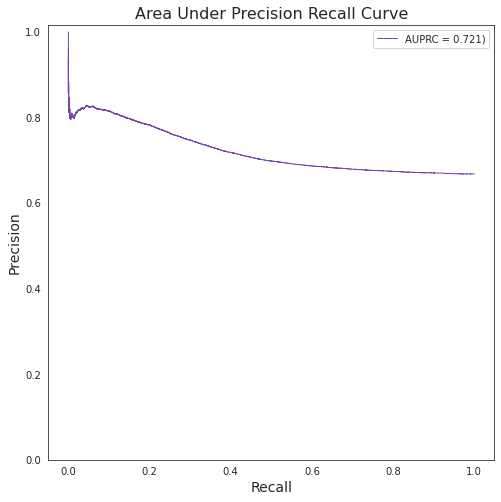

In [0]:
# Extract AUPRC & AP
from sklearn.metrics import auc

def plot_AUPRC(y_true, y_score, title='Area Under Precision Recall Curve'):
    sns.set_style('white')
    plt.figure(figsize=(8,8))

    # Compute precision-recall pairs
    precision, recall, thresholds = precision_recall_curve(y_true, y_score[:, 1])
    # Compute AUPRC
    auprc = auc(recall, precision)
    plt.plot(recall, precision, color="#663399", lw=1, alpha=0.9,
             label=f'AUPRC = {round(auprc, 3)})'
             )
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.ylim(bottom=0)
    plt.title(title, fontsize=16)
    plt.legend()
    plt.show()

plot_AUPRC(y_test, y_test_pred_prob)

In [0]:
target_names = ['class ' + str(x) for x in range(2)]
val_classification_report = classification_report(y_test, y_test_pred, target_names=target_names)
print("Validation Set - Classification Report:")
print(val_classification_report)

Validation Set - Classification Report:
              precision    recall  f1-score   support

     class 0       0.35      0.32      0.34     61798
     class 1       0.68      0.71      0.69    124689

    accuracy                           0.58    186487
   macro avg       0.52      0.52      0.52    186487
weighted avg       0.57      0.58      0.58    186487



In [0]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_matrix = conf_matrix/conf_matrix.sum(axis=1, keepdims=True) * 100 #Convert to percentage
conf_matrix

Out[39]: array([[32.08356257, 67.91643743],
       [28.90631892, 71.09368108]])

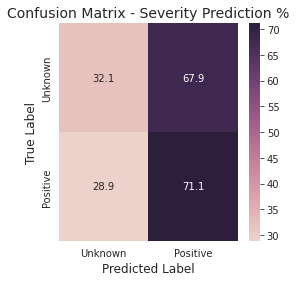

In [0]:
def plot_conf_matrix_high(conf_matrix):
    """Plot confusion matrix"""
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.heatmap(
        conf_matrix, annot=True,
        cmap=sns.cubehelix_palette(as_cmap=True),
        xticklabels= ['Unknown', 'Positive'],
        yticklabels= ['Unknown', 'Positive'],
        fmt='.1f'
    )
    ax.set_xlabel("Predicted Label", fontsize=12)
    ax.set_ylabel("True Label", fontsize=12)
    ax.set_title("Confusion Matrix - Severity Prediction %", fontsize=14)
    plt.show()

plot_conf_matrix_high(conf_matrix)

## XGBoost Finetuning

In [0]:
# Import Data From S3 ready for trainin
df_train = spark.read.parquet(f"{s3_bucket}/data/binary_ddi/train_data_embed_150K").cache()
df_val = spark.read.parquet(f"{s3_bucket}/data/binary_ddi/val_data_embed").cache()
df_test = spark.read.parquet(f"{s3_bucket}/data/binary_ddi/test_data_embed").cache()

In [0]:
def objective_function(params):    
    # set the hyperparameters that we want to tune
    max_depth = params["max_depth"]
    n_estimators = params["n_estimators"]
    learning_rate = params["learning_rate"]

    with mlflow.start_run():
        # Build Model
        estimator = XgboostClassifier(
            labelCol="label", 
            featuresCol="features",
            missing=0,
            max_depth=max_depth,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            force_repartition=True,
            num_workers=10
            )
        
        # Training
        model = estimator.fit(df_train)

        # Using F2 for model evaluation
        evaluator = MulticlassClassificationEvaluator(metricName='fMeasureByLabel', beta=2)

        # Evaluation
        preds = model.transform(df_val)
        f2_score = evaluator.evaluate(preds)

        # mlflow logging
        mlflow.log_metric("f2_score", f2_score)

    return f2_score

In [0]:
mlflow.pyspark.ml.autolog(log_models=False)

search_space = {
    "max_depth": hp.randint("max_depth", 3, 10),
    "n_estimators": hp.randint("n_estimators", 10, 60),
    "learning_rate": hp.loguniform("learning_rate", -3, 0),
}

num_evals = 20
trials = Trials()
# trials = SparkTrials(parallelism=10)

best_hyperparam = fmin(fn=objective_function, 
                       space=search_space,
                       algo=tpe.suggest, 
                       max_evals=num_evals,
                       trials=trials,
                       rstate=np.random.default_rng(42))

best_hyperparam

100%|██████████| 20/20 [51:29<00:00, 154.46s/trial, best loss: 0.4736168927216444]
Out[21]: {'learning_rate': 0.05634741419215324, 'max_depth': 3, 'n_estimators': 13}

In [0]:
# Retrain model on train & validation dataset and evaluate on test dataset
with mlflow.start_run():
    max_depth = best_hyperparam['max_depth']
    n_estimators = best_hyperparam['n_estimators']
    learning_rate = best_hyperparam['learning_rate']
    
    estimator = XgboostClassifier(
            labelCol="label", 
            featuresCol="features",
            missing=0,
            max_depth=max_depth,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            force_repartition=True,
            num_workers=10
            )
    
    combined_df = df_train.union(df_val) # Combine train & validation together

    model = estimator.fit(combined_df)

    # Using F2 for model evaluation
    evaluator = MulticlassClassificationEvaluator(metricName='fMeasureByLabel', beta=2)

    # Evaluation
    preds = model.transform(df_test)
    f2_score = evaluator.evaluate(preds)
    print('F2 Score Test Data:', f2_score)

    # Log param and metrics for the final model
    mlflow.spark.log_model(model, "XGBoost-model")

F2 Score Test Data: 0.40899364491995815


2023/06/28 03:30:09 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().


In [0]:
# def xgboost_training(df, featuresCol='pcaFeatures100', labelCol='label'):
#     """XGBoost Model Training and Cross Validation"""
#     # Model
#     # xgb = XgboostClassifier(featuresCol='pcaFeatures100', labelCol='label', 
#     #                         num_workers=8, missing=0.0)
#     xgb = SparkXGBClassifier(
#         features_col='pcaFeatures100',
#         label_col='label',
#         num_workers=8)
 
#     paramGrid = ParamGridBuilder()\
#                 .addGrid(xgb.max_depth, [5, 10, 15])\
#                 .addGrid(xgb.n_estimators, [15, 30, 50])\
#                 .build()

#     # Use F1 for evaluator
#     evaluator = MulticlassClassificationEvaluator(metricName='fMeasureByLabel'
#                                                   ,beta=1
#                                                   ,labelCol=labelCol
#                                                   ,predictionCol="prediction"
#                                                   )
    
#     # run cross validation 
#     cv = CrossValidator(estimator=xgb, estimatorParamMaps=paramGrid, evaluator=evaluator,
#                         numFolds=5, collectSubModels=True, parallelism=8)
    
#     print('Training...')
#     cvModel = cv.fit(df)
#     bestModel = cvModel.bestModel
    
#     return cvModel, bestModel

# # cvModel, bestModel = xgboost_training(df_train, featuresCol='pcaFeatures100')

In [0]:
# Get predictions for Cross Validation test data
train_predictions = model.transform(df_train)
val_predictions = model.transform(df_val)
test_predictions = model.transform(df_test)

# Print data schema
val_predictions.printSchema()
display(val_predictions.take(1))

root
 |-- vectorized_features: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- pcaFeatures100: vector (nullable = true)
 |-- label: integer (nullable = true)
 |-- label2: double (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- prediction: double (nullable = true)
 |-- probability: vector (nullable = true)



vectorized_features features pcaFeatures100 label label2 rawPrediction prediction probability Map(vectorType -> dense, length -> 600, values -> List(0.127000093460083, 0.26574239134788513, 0.23947370052337646, 0.2668148875236511, 0.2880091965198517, 0.33866700530052185, 0.25806450843811035, 0.2592378854751587, 0.1833869069814682, 0.13366380333900452, 0.16672390699386597, 0.14530779421329498, 0.16433730721473694, 0.17960530519485474, 0.10810969769954681, 0.28843000531196594, 0.2619813084602356, 0.22975189983844757, 0.1567724049091339, 0.16064390540122986, 0.1524001955986023, 0.25456660985946655, 0.0, 0.2794002890586853, 0.2963336110115051, 0.2765204906463623, 0.14588919281959534, 0.16395649313926697, 0.21251189708709717, 0.18215300142765045, 0.2134028971195221, 0.15966929495334625, 0.22170959413051605, 0.07332359999418259, 0.16652509570121765, 0.4120427966117859, 0.20320020616054535, 0.2358333021402359, 0.23007890582084656, 0.09962709993124008, 0.08032190054655075, 0.17269480228424072, 0.20739029347896576, 0.15554280579090118, 0.24195539951324463, 0.20739029347896576, 0.16433730721473694, 0.21951760351657867, 0.1939958930015564, 0.17481499910354614, 0.20365330576896667, 0.2694079875946045, 0.22170959413051605, 0.19145989418029785, 0.2621521055698395, 0.5080004930496216, 0.14368419349193573, 0.20739029347896576, 0.719667375087738, 0.24670690298080444, 0.22450660169124603, 0.2715376913547516, 0.25012218952178955, 0.2213871031999588, 0.15475520491600037, 0.22662359476089478, 0.20395079255104065, 0.248909592628479, 0.2566325068473816, 0.36293309926986694, 0.1760483980178833, 0.10439349710941315, 0.28049638867378235, 0.16064390540122986, 0.24287070333957672, 0.2046792060136795, 0.18759159743785858, 0.23417669534683228, 0.2259330004453659, 0.3246172070503235, 0.1939958930015564, 0.1717354953289032, 0.24906769394874573, 0.17686310410499573, 0.22634799778461456, 0.1703885942697525, 0.11422870308160782, 0.1539473980665207, 0.20080479979515076, 0.3874585032463074, 0.2430834025144577, 0.19925419986248016, 0.24082329869270325, 0.3236480951309204, 0.29604819416999817, 0.05986839905381203, 0.10233960300683975, 0.20835720002651215, 0.244411900639534, 0.1725592017173767, 0.1870608925819397, 0.18072429299354553, 0.314309298992157, 0.21552640199661255, 0.5002443194389343, 0.24217970669269562, 0.15554280579090118, 0.19099409878253937, 0.14802409708499908, 0.21780340373516083, 0.07332359999418259, 0.16971109807491302, 0.27076518535614014, 0.14967109262943268, 0.19354839622974396, 0.1524001955986023, 0.0, 0.20739029347896576, 0.19714240729808807, 0.1989710032939911, 0.243688702583313, 0.20320020616054535, 0.20878690481185913, 0.11219850182533264, 0.1723138988018036, 0.1917268931865692, 0.13283610343933105, 0.31265270709991455, 0.18247920274734497, 0.2122499942779541, 0.20119820535182953, 0.195529505610466, 0.18396879732608795, 0.1984080970287323, 0.3486948013305664, 0.16129030287265778, 0.32258060574531555, 0.18953560292720795, 0.12108989804983139, 0.13912169635295868, 0.22225019335746765, 0.21621939539909363, 0.22953900694847107, 0.232833594083786, 0.17960530519485474, 0.3394221067428589, 0.127000093460083, 0.2318693995475769, 0.18302670121192932, 0.1600050926208496, 0.21561439335346222, 0.1886667013168335, 0.12361279875040054, 0.10479249805212021, 0.1717354953289032, 0.246506005525589, 0.3012850880622864, 0.2743515968322754, 0.1870608925819397, 0.1616573929786682, 0.1814665049314499, 0.17686310410499573, 0.19834089279174805, 0.35199469327926636, 0.23621539771556854, 0.14802409708499908, 0.16652509570121765, 0.20365330576896667, 0.2963336110115051, 0.17686310410499573, 0.14920659363269806, 0.18503740429878235, 0.1609726995229721, 0.13470399379730225, 0.23123329877853394, 0.2613641023635864, 0.1833869069814682, 0.18423110246658325, 0.13538259267807007, 0.22170959413051605, 0.2739745080471039, 0.248909592628479, 0.1862419992685318, 0.13340750336647034, 0.1306820958852768, 0.24906769394874573, 0.2623302936553955, 0.11503949761390686, 0.23958380520343

In [0]:
# Convert to numpy array for evaluating with sklear & plotting
train_predictions_df = train_predictions.select("label", "prediction", "probability").toPandas()
y_train = train_predictions_df["label"].values
y_train_pred = train_predictions_df["prediction"].values
y_train_pred_prob = train_predictions_df["probability"].values
y_train_pred_prob = np.array([np.array(y) for y in y_train_pred_prob])

# Convert to numpy array for evaluating with sklear & plotting - Val data
val_predictions_df = val_predictions.select("label", "prediction", "probability").toPandas()
y_val = val_predictions_df["label"].values
y_val_pred = val_predictions_df["prediction"].values
y_val_pred_prob = val_predictions_df["probability"].values
y_val_pred_prob = np.array([np.array(y) for y in y_val_pred_prob])

# Convert to numpy array for evaluating with sklear & plotting - Test data
test_predictions_df = test_predictions.select("label", "prediction", "probability").toPandas()
y_test = test_predictions_df["label"].values
y_test_pred = test_predictions_df["prediction"].values
y_test_pred_prob = test_predictions_df["probability"].values
y_test_pred_prob = np.array([np.array(y) for y in y_test_pred_prob])

print(y_train_pred_prob.shape)
print(y_val_pred_prob.shape)
print(y_test_pred_prob.shape)

(299117, 2)
(237777, 2)
(186487, 2)


In [0]:
def model_evaluation(y_true, y_pred, prefix="Training"):
    f2_macro =  metrics.fbeta_score(y_true, y_pred, average="binary", pos_label=1, beta=2)
    print(f"{prefix} F2-score: {round(f2_macro,4)}")

    mcc = metrics.matthews_corrcoef(y_true, y_pred)
    print(f"{prefix} Matthew Correlation Coefficient: {round(mcc,4)}")

    recall_macro = metrics.recall_score(y_true, y_pred, average="binary", pos_label=1)
    print(f"{prefix} Recall: {round(recall_macro,4)}")

    precision_macro = metrics.precision_score(y_true, y_pred, average="binary", pos_label=1)
    print(f"{prefix} Precision: {round(precision_macro,4)}")

    accuracy_macro = metrics.accuracy_score(y_true, y_pred)
    print(f"{prefix} Accuracy: {round(accuracy_macro,4)}")

# Evaluation - Macro F1 Score
model_evaluation(y_train, y_train_pred, prefix="Training")
print()
model_evaluation(y_val, y_val_pred, prefix="Validation")
print()
model_evaluation(y_test, y_test_pred, prefix="Testing")

Training F2-score: 0.6625
Training Matthew Correlation Coefficient: 0.2044
Training Recall: 0.685
Training Precision: 0.5858
Training Accuracy: 0.6006

Validation F2-score: 0.7996
Validation Matthew Correlation Coefficient: 0.4046
Validation Recall: 0.8269
Validation Precision: 0.7064
Validation Accuracy: 0.7099

Testing F2-score: 0.6959
Testing Matthew Correlation Coefficient: 0.1046
Testing Recall: 0.6939
Testing Precision: 0.704
Testing Accuracy: 0.6003


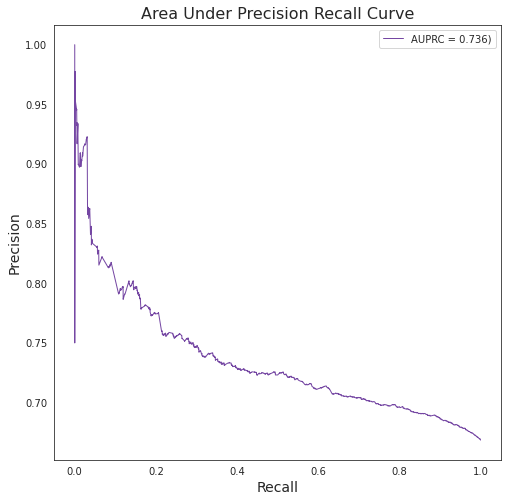

In [0]:
from sklearn.metrics import auc

# Extract AUPRC & AP
def plot_AUPRC(y_true, y_score, title='Area Under Precision Recall Curve'):
    sns.set_style('white')
    plt.figure(figsize=(8,8))

    # Compute precision-recall pairs
    precision, recall, thresholds = precision_recall_curve(y_true, y_score[:, 1])
    # Compute AUPRC
    auprc = auc(recall, precision)
    plt.plot(recall, precision, color="#663399", lw=1, alpha=0.9,
             label=f'AUPRC = {round(auprc, 3)})'
             )
    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.ylim(bottom=0)
    plt.title(title, fontsize=16)
    plt.legend()
    plt.show()

plot_AUPRC(y_test, y_test_pred_prob)

In [0]:
target_names = ['class ' + str(x) for x in range(2)]
val_classification_report = classification_report(y_test, y_test_pred, target_names=target_names)
print("Validation Set - Classification Report:")
print(val_classification_report)

Validation Set - Classification Report:
              precision    recall  f1-score   support

     class 0       0.40      0.41      0.41     61798
     class 1       0.70      0.69      0.70    124689

    accuracy                           0.60    186487
   macro avg       0.55      0.55      0.55    186487
weighted avg       0.60      0.60      0.60    186487



In [0]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_matrix = conf_matrix/conf_matrix.sum(axis=1, keepdims=True) * 100 #Convert to percentage
conf_matrix

Out[28]: array([[41.13563546, 58.86436454],
       [30.6057471 , 69.3942529 ]])

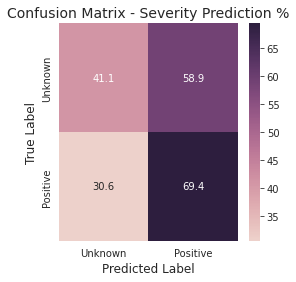

In [0]:
def plot_conf_matrix_high(conf_matrix):
    """Plot confusion matrix"""
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.heatmap(
        conf_matrix, annot=True,
        cmap=sns.cubehelix_palette(as_cmap=True),
        xticklabels= ['Unknown', 'Positive'],
        yticklabels= ['Unknown', 'Positive'],
        fmt='.1f'
    )
    ax.set_xlabel("Predicted Label", fontsize=12)
    ax.set_ylabel("True Label", fontsize=12)
    ax.set_title("Confusion Matrix - Severity Prediction %", fontsize=14)
    plt.show()

plot_conf_matrix_high(conf_matrix)